# Data Exploration and Cleaning

Before building the model, I want to understand the nature of the data we have. There are several data sources we're using, all index by date.

**Outcome Data**
- SAR response. This data set indicates whether or not there was a SAR call on a specified day.

**Features**
- Date features
- Weather from [NOAA](https://www.ncdc.noaa.gov/cdo-web/)


## SAR Response Data 

First, let's dig into the SAR response data. How often does a mission happen?

In [139]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline



In [140]:
sar_header = ['DEM', 'date', 'name', 'responders', 'hours', 'miles']
sar_data = pd.read_csv('KCSARA.csv', date_parser=True, names=sar_header, header=None)
pd.DataFrame(sar_data)

,DEM,date,name,responders,hours,miles
0,06-1499,1/1/1800,Scenic Hotsprings,0.0,NaN,NaN
1,313531,1/1/1800,Kennedy Hot Springs (Pack Out),7.0,19.50,290.0
2,07-688,1/1/1800,Seattle,0.0,NaN,NaN
3,NaN,2/16/64,North Bend River Search,0.0,NaN,NaN
4,NaN,8/8/64,La Bohn Gap Rescue,0.0,NaN,NaN
5,64-0001,10/24/64,Denny Creek Evac,0.0,NaN,NaN
6,64-0002,11/1/64,Grass Mountain,0.0,NaN,NaN
7,64-0003,11/2/64,Lake Hancock Lost Hunter,0.0,NaN,NaN
8,64-0004,11/7/64,Redmond Missing Boys,0.0,NaN,NaN
9,64-0005,11/14/64,Kelso Lost Hunter,0.0,NaN,NaN


In [141]:
sar_data.head()

,DEM,date,name,responders,hours,miles
0,06-1499,1/1/1800,Scenic Hotsprings,0.0,NaN,NaN
1,313531,1/1/1800,Kennedy Hot Springs (Pack Out),7.0,19.5,290.0
2,07-688,1/1/1800,Seattle,0.0,NaN,NaN
3,NaN,2/16/64,North Bend River Search,0.0,NaN,NaN
4,NaN,8/8/64,La Bohn Gap Rescue,0.0,NaN,NaN


In [142]:
sar_data.tail()

,DEM,date,name,responders,hours,miles
2707,NaN,NaN,NaN,NaN,NaN,NaN
2708,NaN,NaN,NaN,NaN,NaN,NaN
2709,NaN,NaN,NaN,NaN,NaN,NaN
2710,NaN,NaN,NaN,NaN,NaN,NaN
2711,NaN,NaN,NaN,NaN,NaN,NaN


In [143]:
sar_data.shape

(2712, 6)

### Missions per year

There are NAs in the date column, we need to get rid of those

In [144]:
sar_data = sar_data[pd.notnull(sar_data.date)]

In [145]:
sar_data['year'] = pd.DatetimeIndex(sar_data['date']).year
sar_data['week'] = pd.DatetimeIndex(sar_data['date']).week

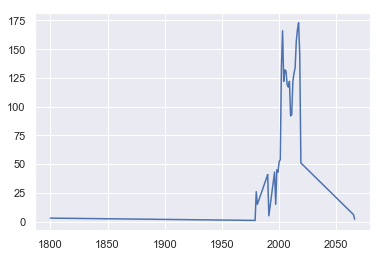

In [146]:
missions_per_year = sar_data.year.value_counts()
missions_per_year
plt.plot(missions_per_year.sort_index())
plt.show()

Clearly some weirdness happening here, lets cut the data to remove anything from before 1980 and in the future.

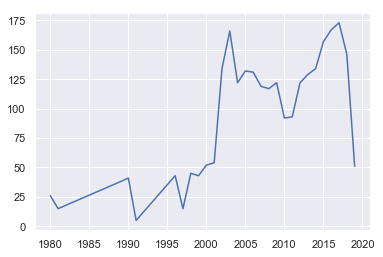

In [147]:
sar_data = sar_data[(sar_data.year < 2020) & (sar_data.year > 1979)]
missions_per_year = sar_data.year.value_counts()
missions_per_year
plt.plot(missions_per_year.sort_index())
plt.show()

It seems to me that the data prior to 2001 is incomplete in some instances and likely follows a different model than the years proir to 2001. Let's focus this analysis on the missions after the spike. For example, in 1991 there are only missions in months 1-4, even though we know the most popular months are the summer months. This is seen in several other years as well.

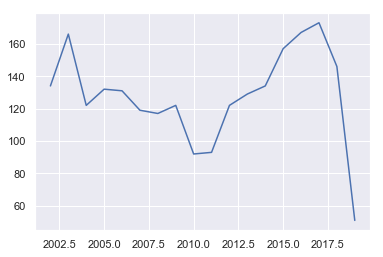

In [148]:
sar_data = sar_data[(sar_data.year < 2020) & (sar_data.year > 2001)]
missions_per_year = sar_data.year.value_counts()
missions_per_year
plt.plot(missions_per_year.sort_index())
plt.show()

### Missions per week

As shown below, the summer weeks get the highest mission density.

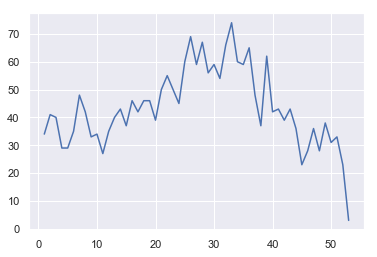

In [150]:
missions_per_week = sar_data.week.value_counts()
missions_per_week
plt.plot(missions_per_week.sort_index())
plt.show()

### Clean data to include all dates and a mission class

Before we can do any ML, we need a table with all dates that indicates whether a mission happened or not. The rest of the variables in this table aren't important for our predictions.

In [189]:
sar_data.date = sar_data.date.astype('datetime64[ns]')
date_range = pd.date_range(start='1/1/2002', end='4/01/2019')

clean_table = []

for d in date_range:
    if sar_data.date.isin([d]).any():
        clean_table.append([d,1])
    else:
        clean_table.append([d,0])
               
sar_clean = pd.DataFrame(clean_table)

pandas.core.frame.DataFrame

In [227]:
sar_clean.columns = ['DATE','MISSION']
sar_clean.head()

,DATE,MISSION
0,2002-01-01,1
1,2002-01-02,0
2,2002-01-03,1
3,2002-01-04,0
4,2002-01-05,1


## Weather Data

We're pulling data from two weather stations in Washington State. Boeing field is a little south of Seattle and will represent the 'city' weather, and Mount Gardner is a weather station in the Cascade Mountain Range East of Seattle and will report on the 'mountain' weather in the model.

I'm not sure what to expect, poor weather will mean less people in the mountains, but it could also mean more dangerous conditions for the people that are out.

In [217]:
boeing = pd.read_csv('boeing.csv', parse_dates=[2])
boeing.describe()

,AWND,FMTM,PGTM,PRCP,TAVG,TMAX,TMIN,TSUN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT05,WT08,WT10
count,6299.000000,1461.000000,6156.000000,6302.000000,1307.000000,6286.000000,6286.000000,928.0,6309.000000,6309.000000,6309.000000,6309.000000,1694.0,138.0,40.0,1.0,614.0,1.0
mean,5.265264,1389.337440,1354.393762,0.101831,54.160673,61.200127,46.325167,0.0,213.889681,222.258678,13.580472,19.994278,1.0,1.0,1.0,1.0,1.0,1.0
std,2.630277,549.960908,516.171642,0.235165,10.433713,12.532549,9.799496,0.0,76.979837,72.996940,4.551554,6.784557,0.0,0.0,0.0,NaN,0.0,NaN
min,0.000000,7.000000,0.000000,0.000000,0.000000,27.000000,1.000000,0.0,10.000000,10.000000,4.900000,4.900000,1.0,1.0,1.0,1.0,1.0,1.0
25%,3.360000,1136.000000,1125.000000,0.000000,46.000000,52.000000,39.000000,0.0,160.000000,180.000000,10.100000,16.100000,1.0,1.0,1.0,1.0,1.0,1.0
50%,4.700000,1450.000000,1429.000000,0.000000,53.000000,60.000000,46.000000,0.0,190.000000,220.000000,13.000000,18.100000,1.0,1.0,1.0,1.0,1.0,1.0
75%,6.710000,1724.000000,1658.000000,0.090000,62.000000,70.000000,54.000000,0.0,300.000000,290.000000,16.100000,23.000000,1.0,1.0,1.0,1.0,1.0,1.0
max,18.790000,2359.000000,2359.000000,4.040000,82.000000,124.000000,72.000000,0.0,360.000000,360.000000,40.900000,159.000000,1.0,1.0,1.0,1.0,1.0,1.0


In [218]:
gardner = pd.read_csv('gardner.csv', parse_dates=[2])
gardner.describe()

,AWND,PRCP,SNWD,TAVG,TMAX,TMIN,TOBS,WESD
count,2464.000000,6299.000000,5063.000000,6301.000000,6301.000000,6299.000000,6300.000000,6305.000000
mean,0.573957,0.289078,13.912107,44.026504,50.710522,39.065248,41.653492,4.759873
std,0.619283,0.519665,21.528531,11.294813,14.229234,9.639733,10.048830,7.847762
min,0.000000,0.000000,0.000000,5.000000,8.000000,3.000000,4.000000,0.000000
25%,0.000000,0.000000,0.000000,35.000000,39.000000,32.000000,34.000000,0.000000
50%,0.450000,0.000000,0.000000,42.000000,48.000000,38.000000,41.000000,0.000000
75%,0.890000,0.400000,26.000000,52.000000,61.000000,46.000000,49.000000,8.100000
max,3.580000,6.500000,110.000000,77.000000,94.000000,71.000000,76.000000,42.400000


In [221]:
print(boeing.shape, gardner.shape)
print(boeing.head())
print(gardner.head())

(6309, 21) (6305, 11)
       STATION                         NAME       DATE  AWND    FMTM    PGTM  \
0  USW00024234  SEATTLE BOEING FIELD, WA US 2002-01-01  5.14  1129.0  1125.0   
1  USW00024234  SEATTLE BOEING FIELD, WA US 2002-01-02  4.70   354.0   555.0   
2  USW00024234  SEATTLE BOEING FIELD, WA US 2002-01-03  6.93  2031.0  1416.0   
3  USW00024234  SEATTLE BOEING FIELD, WA US 2002-01-04  1.12    58.0  1113.0   
4  USW00024234  SEATTLE BOEING FIELD, WA US 2002-01-05  3.80  1913.0   519.0   

   PRCP  TAVG  TMAX  TMIN  ...   WDF2  WDF5  WSF2  WSF5  WT01  WT02  WT03  \
0  0.63  45.0  54.0  36.0  ...    130   140  17.0  21.9   NaN   NaN   NaN   
1  0.06  49.0  55.0  43.0  ...    130   130  14.1  17.0   NaN   NaN   NaN   
2  0.01  47.0  55.0  39.0  ...    170   190  14.1  21.0   NaN   NaN   NaN   
3  0.00  49.0  54.0  44.0  ...    120   240   8.1  13.0   NaN   NaN   NaN   
4  0.26  49.0  54.0  43.0  ...    140   210  15.0  17.9   NaN   NaN   NaN   

   WT05  WT08  WT10  
0   NaN   Na

We want tidy data, so let's join on the date.

In [233]:
weather = pd.merge(boeing, gardner, how='inner', on='DATE')
print(weather.shape)
weather.head()


(6297, 31)


,STATION_x,NAME_x,DATE,AWND_x,FMTM,PGTM,PRCP_x,TAVG_x,TMAX_x,TMIN_x,...,STATION_y,NAME_y,AWND_y,PRCP_y,SNWD,TAVG_y,TMAX_y,TMIN_y,TOBS,WESD
0,USW00024234,"SEATTLE BOEING FIELD, WA US",2002-01-01,5.14,1129.0,1125.0,0.63,45.0,54.0,36.0,...,USS0021B21S,"MOUNT GARDNER, WA US",NaN,0.0,NaN,32.0,34.0,30.0,33.0,11.6
1,USW00024234,"SEATTLE BOEING FIELD, WA US",2002-01-02,4.70,354.0,555.0,0.06,49.0,55.0,43.0,...,USS0021B21S,"MOUNT GARDNER, WA US",NaN,0.4,NaN,33.0,35.0,30.0,30.0,11.0
2,USW00024234,"SEATTLE BOEING FIELD, WA US",2002-01-03,6.93,2031.0,1416.0,0.01,47.0,55.0,39.0,...,USS0021B21S,"MOUNT GARDNER, WA US",NaN,0.2,NaN,33.0,36.0,30.0,34.0,11.2
3,USW00024234,"SEATTLE BOEING FIELD, WA US",2002-01-04,1.12,58.0,1113.0,0.00,49.0,54.0,44.0,...,USS0021B21S,"MOUNT GARDNER, WA US",NaN,0.1,NaN,33.0,36.0,31.0,32.0,11.2
4,USW00024234,"SEATTLE BOEING FIELD, WA US",2002-01-05,3.80,1913.0,519.0,0.26,49.0,54.0,43.0,...,USS0021B21S,"MOUNT GARDNER, WA US",NaN,0.2,NaN,33.0,35.0,32.0,33.0,11.5


The NANs for the weather codes essentially mean that that weather type didn't happen, so I'll replace them with a 0

In [235]:
weather = weather.fillna(0)
weather.head()

,STATION_x,NAME_x,DATE,AWND_x,FMTM,PGTM,PRCP_x,TAVG_x,TMAX_x,TMIN_x,...,STATION_y,NAME_y,AWND_y,PRCP_y,SNWD,TAVG_y,TMAX_y,TMIN_y,TOBS,WESD
0,USW00024234,"SEATTLE BOEING FIELD, WA US",2002-01-01,5.14,1129.0,1125.0,0.63,45.0,54.0,36.0,...,USS0021B21S,"MOUNT GARDNER, WA US",0.0,0.0,0.0,32.0,34.0,30.0,33.0,11.6
1,USW00024234,"SEATTLE BOEING FIELD, WA US",2002-01-02,4.70,354.0,555.0,0.06,49.0,55.0,43.0,...,USS0021B21S,"MOUNT GARDNER, WA US",0.0,0.4,0.0,33.0,35.0,30.0,30.0,11.0
2,USW00024234,"SEATTLE BOEING FIELD, WA US",2002-01-03,6.93,2031.0,1416.0,0.01,47.0,55.0,39.0,...,USS0021B21S,"MOUNT GARDNER, WA US",0.0,0.2,0.0,33.0,36.0,30.0,34.0,11.2
3,USW00024234,"SEATTLE BOEING FIELD, WA US",2002-01-04,1.12,58.0,1113.0,0.00,49.0,54.0,44.0,...,USS0021B21S,"MOUNT GARDNER, WA US",0.0,0.1,0.0,33.0,36.0,31.0,32.0,11.2
4,USW00024234,"SEATTLE BOEING FIELD, WA US",2002-01-05,3.80,1913.0,519.0,0.26,49.0,54.0,43.0,...,USS0021B21S,"MOUNT GARDNER, WA US",0.0,0.2,0.0,33.0,35.0,32.0,33.0,11.5


And finally merge the weather with the mission data to get our final dataset to use.


In [236]:
data = pd.merge(sar_clean, weather, how='inner', on='DATE')

In [237]:
print(data.shape)
data.head()


(6281, 32)


,DATE,MISSION,STATION_x,NAME_x,AWND_x,FMTM,PGTM,PRCP_x,TAVG_x,TMAX_x,...,STATION_y,NAME_y,AWND_y,PRCP_y,SNWD,TAVG_y,TMAX_y,TMIN_y,TOBS,WESD
0,2002-01-01,1,USW00024234,"SEATTLE BOEING FIELD, WA US",5.14,1129.0,1125.0,0.63,45.0,54.0,...,USS0021B21S,"MOUNT GARDNER, WA US",0.0,0.0,0.0,32.0,34.0,30.0,33.0,11.6
1,2002-01-02,0,USW00024234,"SEATTLE BOEING FIELD, WA US",4.70,354.0,555.0,0.06,49.0,55.0,...,USS0021B21S,"MOUNT GARDNER, WA US",0.0,0.4,0.0,33.0,35.0,30.0,30.0,11.0
2,2002-01-03,1,USW00024234,"SEATTLE BOEING FIELD, WA US",6.93,2031.0,1416.0,0.01,47.0,55.0,...,USS0021B21S,"MOUNT GARDNER, WA US",0.0,0.2,0.0,33.0,36.0,30.0,34.0,11.2
3,2002-01-04,0,USW00024234,"SEATTLE BOEING FIELD, WA US",1.12,58.0,1113.0,0.00,49.0,54.0,...,USS0021B21S,"MOUNT GARDNER, WA US",0.0,0.1,0.0,33.0,36.0,31.0,32.0,11.2
4,2002-01-05,1,USW00024234,"SEATTLE BOEING FIELD, WA US",3.80,1913.0,519.0,0.26,49.0,54.0,...,USS0021B21S,"MOUNT GARDNER, WA US",0.0,0.2,0.0,33.0,35.0,32.0,33.0,11.5
